In [3]:
import pandas as pd
import numpy as np
from math import floor, ceil
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mtick

In [ ]:
try:
    df = pd.read_csv('nfl_df.csv')
except:
    df = pd.concat([pd.read_csv('reg_pbp_20'+x+'.csv') for x in ['19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '09']], ignore_index=True)
    pd.save_csv('nfl_df.csv')

In [5]:
df1 = df[['yardline_100', 'down', 'ydstogo', 'yards_gained', 'no_huddle', 'qb_spike', 'air_yards', 'qb_hit', 'pass_attempt', 'complete_pass', 'passer_player_name']].copy()

In [6]:
df1.dropna(inplace=True)

In [7]:
df1.rename(columns={'yardline_100': 'yards_to_endzone', 'ydstogo': 'yards_to_go'}, inplace=True)

In [8]:
df1 = df1[(df1['pass_attempt']==1)&(df1['air_yards']>=-2)]

In [9]:
df1['yards_into_redzone'] = 0

In [10]:
df1.loc[df1.yards_to_endzone<20, 'yards_into_redzone'] = 20-df1.loc[df1.yards_to_endzone<20, 'yards_to_endzone']

In [11]:
df1 = df1.astype({'yards_to_endzone': int, 'down': int, 'yards_gained': int, 'air_yards': int, 'qb_hit': int, 'pass_attempt': int, 'complete_pass': int, 'yards_into_redzone': int})

In [12]:
df1.drop(columns=['pass_attempt'], inplace=True)
#df1.drop(index=np.random.choice(df1[df1['complete_pass']==1].index, 25000, replace=False), columns=['pass_attempt'], inplace=True)

In [13]:
df1.reset_index(drop=True, inplace=True)

In [14]:
df1.head()

,yards_to_endzone,down,yards_to_go,yards_gained,no_huddle,qb_spike,air_yards,qb_hit,complete_pass,passer_player_name,yards_into_redzone
0,75,2,10,0,0,0,-1,0,1,A.Rodgers,0
1,47,2,5,0,0,0,2,0,0,M.Trubisky,0
2,40,1,10,0,0,0,15,0,0,M.Trubisky,0
3,88,1,10,0,0,0,3,0,0,A.Rodgers,0
4,21,3,5,1,0,0,0,0,1,M.Trubisky,0


In [16]:
X_comp_unscaled = df1.copy().drop(columns=['yards_to_endzone', 'complete_pass', 'passer_player_name'])
comp_scaler = MinMaxScaler().fit(X_comp_unscaled)
X_comp = comp_scaler.transform(X_comp_unscaled)
y_comp = df1['complete_pass'].copy()

In [17]:
X_ypa_unscaled = df1.copy().drop(columns=['down', 'yards_to_go', 'yards_gained', 'no_huddle', 'qb_spike', 'qb_hit', 'passer_player_name', 'yards_into_redzone'])
ypa_scaler = MinMaxScaler().fit(X_ypa_unscaled)
X_ypa = ypa_scaler.transform(X_ypa_unscaled)
y_ypa = df1['yards_gained'].copy()

In [18]:
#X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_comp, y_comp)

In [19]:
#X_train_ypa, X_test_ypa, y_train_ypa, y_test_ypa = train_test_split(X_ypa, y_ypa)

In [20]:
clf_comp = MLPRegressor(hidden_layer_sizes=(5)).fit(X_comp, y_comp)
#clf_comp = MLPRegressor(hidden_layer_sizes=(5)).fit(X_train_comp, y_train_comp)

In [21]:
clf_ypa = MLPRegressor(hidden_layer_sizes=(2)).fit(X_ypa, y_ypa)
#clf_ypa = MLPRegressor(hidden_layer_sizes=(2)).fit(X_train_ypa, y_train_ypa)

In [22]:
#clf_comp.score(X_test_comp, y_test_comp)

In [23]:
#clf_ypa.score(X_test_ypa, y_test_ypa)

In [24]:
qbs = ['D.Brees', 'J.Garoppolo', 'T.Bridgewater', 'M.Ryan', 'D.Prescott',
       'K.Cousins', 'C.Wentz', 'T.Brady', 'D.Lock', 'J.Goff', 'P.Mahomes',
       'D.Jones', 'A.Rodgers', 'M.Stafford', 'K.Murray', 'P.Rivers',
       'D.Watson', 'R.Tannehill', 'D.Carr', 'C.Newton', 'B.Roethlisberger',
       'T.Taylor', 'S.Darnold', 'L.Jackson', 'N.Foles', 'R.Wilson',
       'G.Minshew', 'R.Fitzpatrick', 'B.Mayfield', 'D.Haskins', 'J.Allen']

In [25]:
df2_comp = pd.DataFrame(index=qbs, columns=['predicted_completion_percentage', 'actual_completion_percentage', 'difference'])

In [26]:
df2_ypa = pd.DataFrame(index=qbs, columns=['predicted_ypa', 'actual_ypa', 'difference'])

In [27]:
for qb in qbs:
    df3_comp = pd.DataFrame(clf_comp.predict(comp_scaler.transform(df1.copy().drop(columns=['yards_to_endzone', 'complete_pass', 'passer_player_name']))[df1['passer_player_name']==qb]))
    df2_comp.loc[qb, 'predicted_completion_percentage'] = round(df3_comp[0].mean()*100, 1)

In [28]:
for qb in qbs:
    df3_ypa = pd.DataFrame(clf_ypa.predict(ypa_scaler.transform(df1.copy().drop(columns=['down', 'yards_to_go', 'yards_gained', 'no_huddle', 'qb_spike', 'qb_hit', 'passer_player_name', 'yards_into_redzone']))[df1['passer_player_name']==qb]))
    df2_ypa.loc[qb, 'predicted_ypa'] = round(df3_ypa[0].mean(), 2)

In [29]:
percentages = [69.6, 67.5, 65.2, 65.7, 65.8, 66.9, 63.8, 64.3, 64.1, 62.4, 65.9, 61.9, 64.7, 62.5, 64.4, 65.2, 66.8, 63.5, 64.0, 59.6, 65.0, 61.6, 63.8, 59.9, 61.9, 64.5, 60.6, 60.5, 61.5, 58.6, 56.3]
for i in range(31):
    df2_comp.at[qbs[i], 'actual_completion_percentage'] = percentages[i]
    df2_comp.at[qbs[i], 'difference'] = df2_comp.at[qbs[i], 'actual_completion_percentage']-df2_comp.at[qbs[i], 'predicted_completion_percentage']

In [30]:
ypas = [7.86, 8.30, 7.15, 7.48, 7.62, 7.66, 6.91, 7.60, 6.54, 7.61, 8.56, 6.60, 7.79, 7.20, 6.87, 7.88, 8.07, 7.25, 6.88, 7.30, 7.81, 7.02, 6.89, 7.58, 7.01, 7.87, 6.96, 7.06, 7.40, 6.72, 6.61]
for i in range(31):
    df2_ypa.at[qbs[i], 'actual_ypa'] = ypas[i]
    df2_ypa.at[qbs[i], 'difference'] = df2_ypa.at[qbs[i], 'actual_ypa']-df2_ypa.at[qbs[i], 'predicted_ypa']

In [31]:
df2_comp.sort_values('difference', ascending=False, inplace=True)

In [32]:
df2_ypa.sort_values('difference', ascending=False, inplace=True)

In [33]:
df2_comp = df2_comp.astype({'difference': float})

In [34]:
df2_ypa = df2_ypa.astype({'difference': float})

In [35]:
df2_comp

,predicted_completion_percentage,actual_completion_percentage,difference
S.Darnold,58.8,63.8,5.0
D.Jones,58.2,61.9,3.7
N.Foles,59.2,61.9,2.7
J.Allen,53.7,56.3,2.6
P.Mahomes,63.5,65.9,2.4
D.Carr,61.8,64,2.2
B.Mayfield,59.5,61.5,2.0
D.Lock,62.1,64.1,2.0
D.Watson,64.9,66.8,1.9
C.Wentz,62.1,63.8,1.7


In [36]:
df2_ypa

,predicted_ypa,actual_ypa,difference
J.Garoppolo,7.69,8.3,0.61
P.Mahomes,8.22,8.56,0.34
J.Goff,7.29,7.61,0.32
T.Brady,7.32,7.6,0.28
A.Rodgers,7.61,7.79,0.18
L.Jackson,7.46,7.58,0.12
M.Stafford,7.19,7.2,0.01
P.Rivers,7.9,7.88,-0.02
D.Haskins,6.75,6.72,-0.03
K.Cousins,7.7,7.66,-0.04


In [37]:
color_dict = {'D.Brees': 'darkgoldenrod', 'J.Garoppolo': 'firebrick', 'T.Bridgewater': 'dodgerblue', 'M.Ryan': 'darkred', 'D.Prescott': 'midnightblue', 'K.Cousins': 'indigo', 'C.Wentz': 'darkslategrey', 'T.Brady': 'darkred', 'D.Lock': 'orangered', 'J.Goff': 'blue', 'P.Mahomes': 'red', 'D.Jones': 'blue', 'A.Rodgers': 'darkgreen', 'M.Stafford': 'steelblue', 'K.Murray': 'darkred', 'P.Rivers': 'blue', 'D.Watson': 'midnightblue', 'R.Tannehill': 'steelblue', 'D.Carr': 'black', 'C.Newton': 'midnightblue', 'B.Roethlisberger': 'black', 'T.Taylor': 'blue', 'S.Darnold': 'darkgreen', 'L.Jackson': 'indigo', 'N.Foles': 'orangered', 'R.Wilson': 'limegreen', 'G.Minshew': 'darkcyan', 'R.Fitzpatrick': 'lightseagreen', 'B.Mayfield': 'orangered', 'D.Haskins': 'maroon', 'J.Allen': 'blue'}

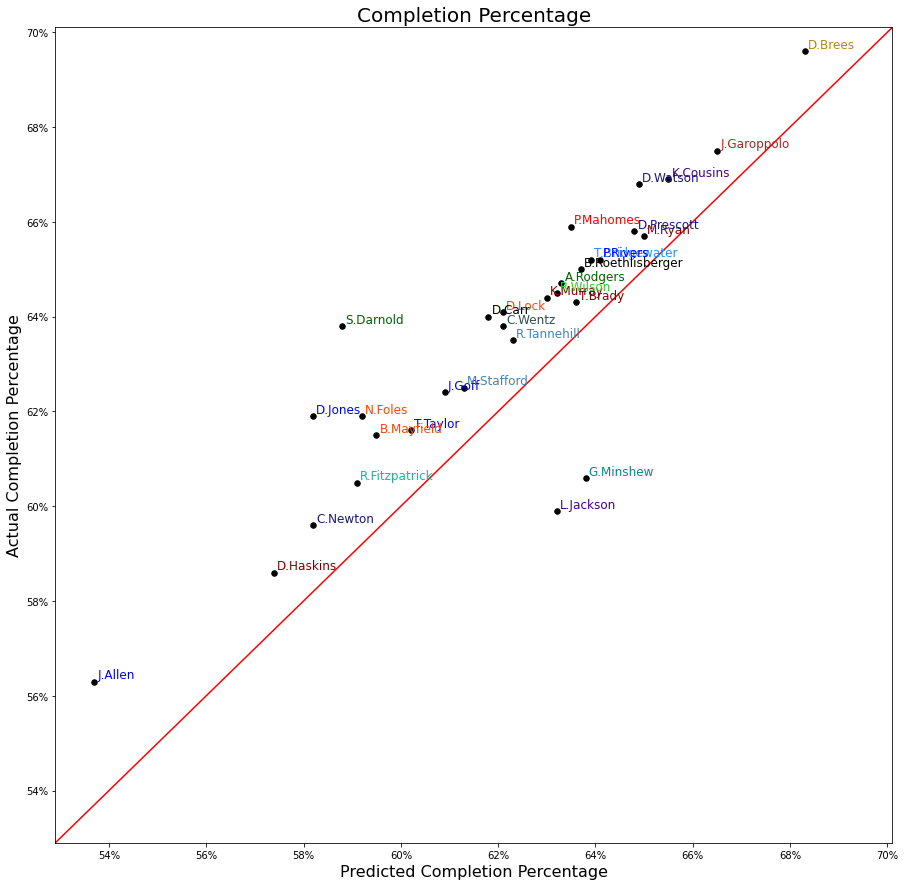

In [38]:
fig_comp, ax_comp = plt.subplots(figsize=(15, 15))
ax_comp.scatter(df2_comp['predicted_completion_percentage'], df2_comp['actual_completion_percentage'], s=30, color='black')
ax_comp.set_xlabel('Predicted Completion Percentage', fontsize=16)
ax_comp.set_ylabel('Actual Completion Percentage', fontsize=16)
ax_comp.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_comp.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_comp.set_title('Completion Percentage', fontsize=20)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax_comp.transAxes
line.set_transform(transform)
ax_comp.add_line(line)
lim_min_comp = floor(min(df2_comp['predicted_completion_percentage'].min(), df2_comp['actual_completion_percentage'].min()))-0.1
lim_max_comp = ceil(max(df2_comp['predicted_completion_percentage'].max(), df2_comp['actual_completion_percentage'].max()))+0.1
plt.xlim(lim_min_comp, lim_max_comp)
plt.ylim(lim_min_comp, lim_max_comp)
for qb in qbs:
    ax_comp.annotate(qb, (df2_comp.loc[qb, 'predicted_completion_percentage'], df2_comp.loc[qb, 'actual_completion_percentage']), color=color_dict[qb], size=12, xytext=(3, 3), textcoords='offset points')
plt.show()

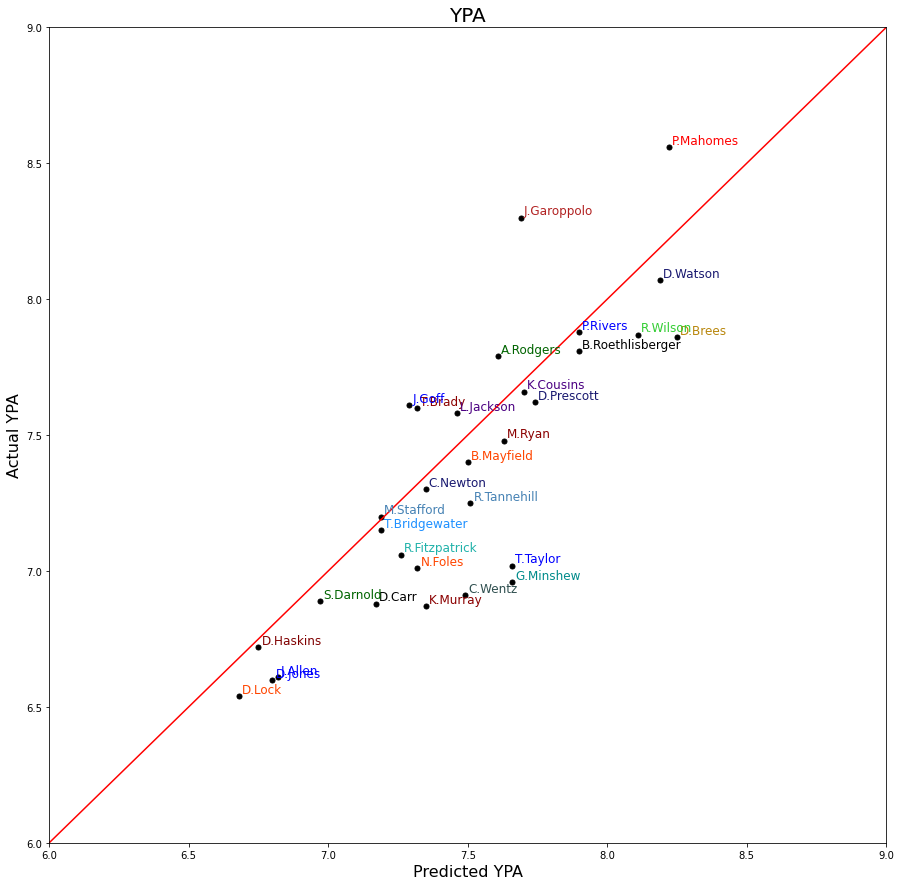

In [39]:
fig_ypa, ax_ypa = plt.subplots(figsize=(15, 15))
ax_ypa.scatter(df2_ypa['predicted_ypa'], df2_ypa['actual_ypa'], s=25, color='black')
ax_ypa.set_xlabel('Predicted YPA', fontsize=16)
ax_ypa.set_ylabel('Actual YPA', fontsize=16)
ax_ypa.set_title('YPA', fontsize=20)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax_ypa.transAxes
line.set_transform(transform)
ax_ypa.add_line(line)
lim_min_ypa = floor(min(df2_ypa['predicted_ypa'].min(), df2_ypa['actual_ypa'].min()))
lim_max_ypa = ceil(max(df2_ypa['predicted_ypa'].max(), df2_ypa['actual_ypa'].max()))
plt.xlim(lim_min_ypa, lim_max_ypa)
plt.ylim(lim_min_ypa, lim_max_ypa)
for qb in qbs:
    ax_ypa.annotate(qb, (df2_ypa.loc[qb, 'predicted_ypa'], df2_ypa.loc[qb, 'actual_ypa']), color=color_dict[qb], size=12, xytext=(3, 3), textcoords='offset points')
plt.show()

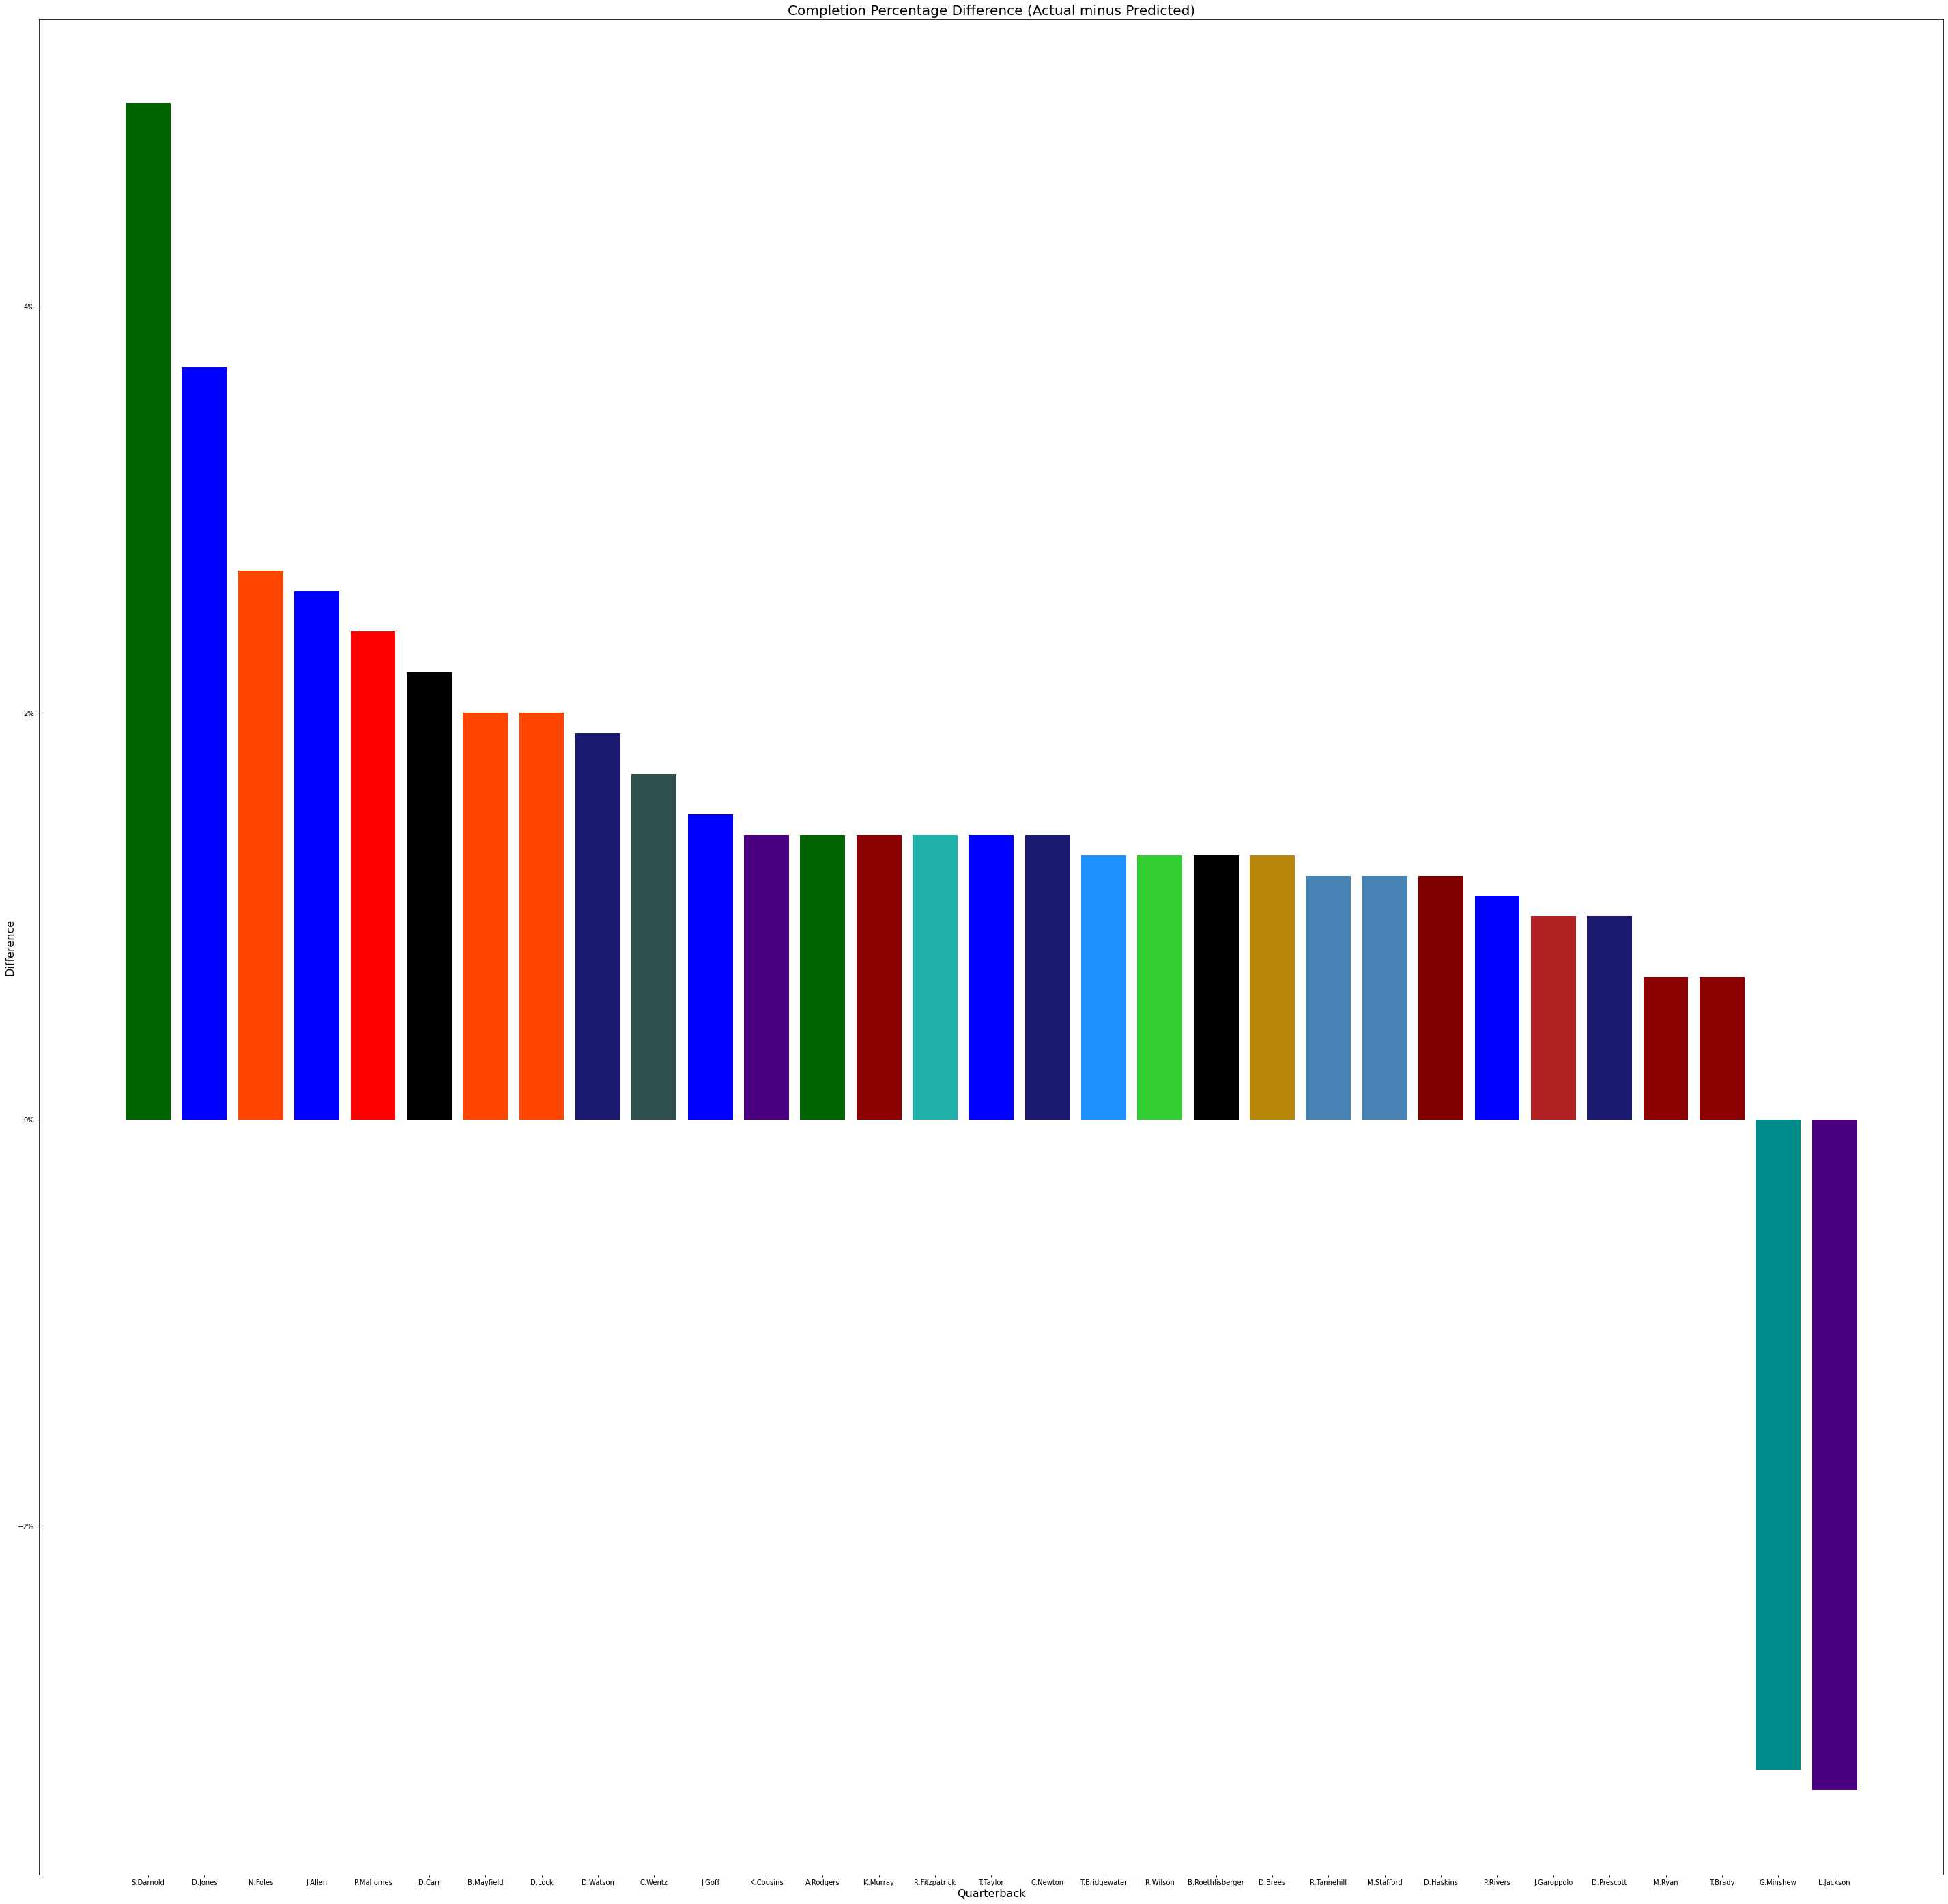

In [40]:
fig_comp_dif, ax_comp_dif = plt.subplots(figsize=(50, 50))
ax_comp_dif.bar(df2_comp.index, df2_comp['difference'], color=[color_dict[qb] for qb in df2_comp.index])
ax_comp_dif.set_xlabel('Quarterback', fontsize=16)
ax_comp_dif.set_ylabel('Difference', fontsize=16)
ax_comp_dif.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_comp_dif.set_title('Completion Percentage Difference (Actual minus Predicted)', fontsize=20)
plt.show()

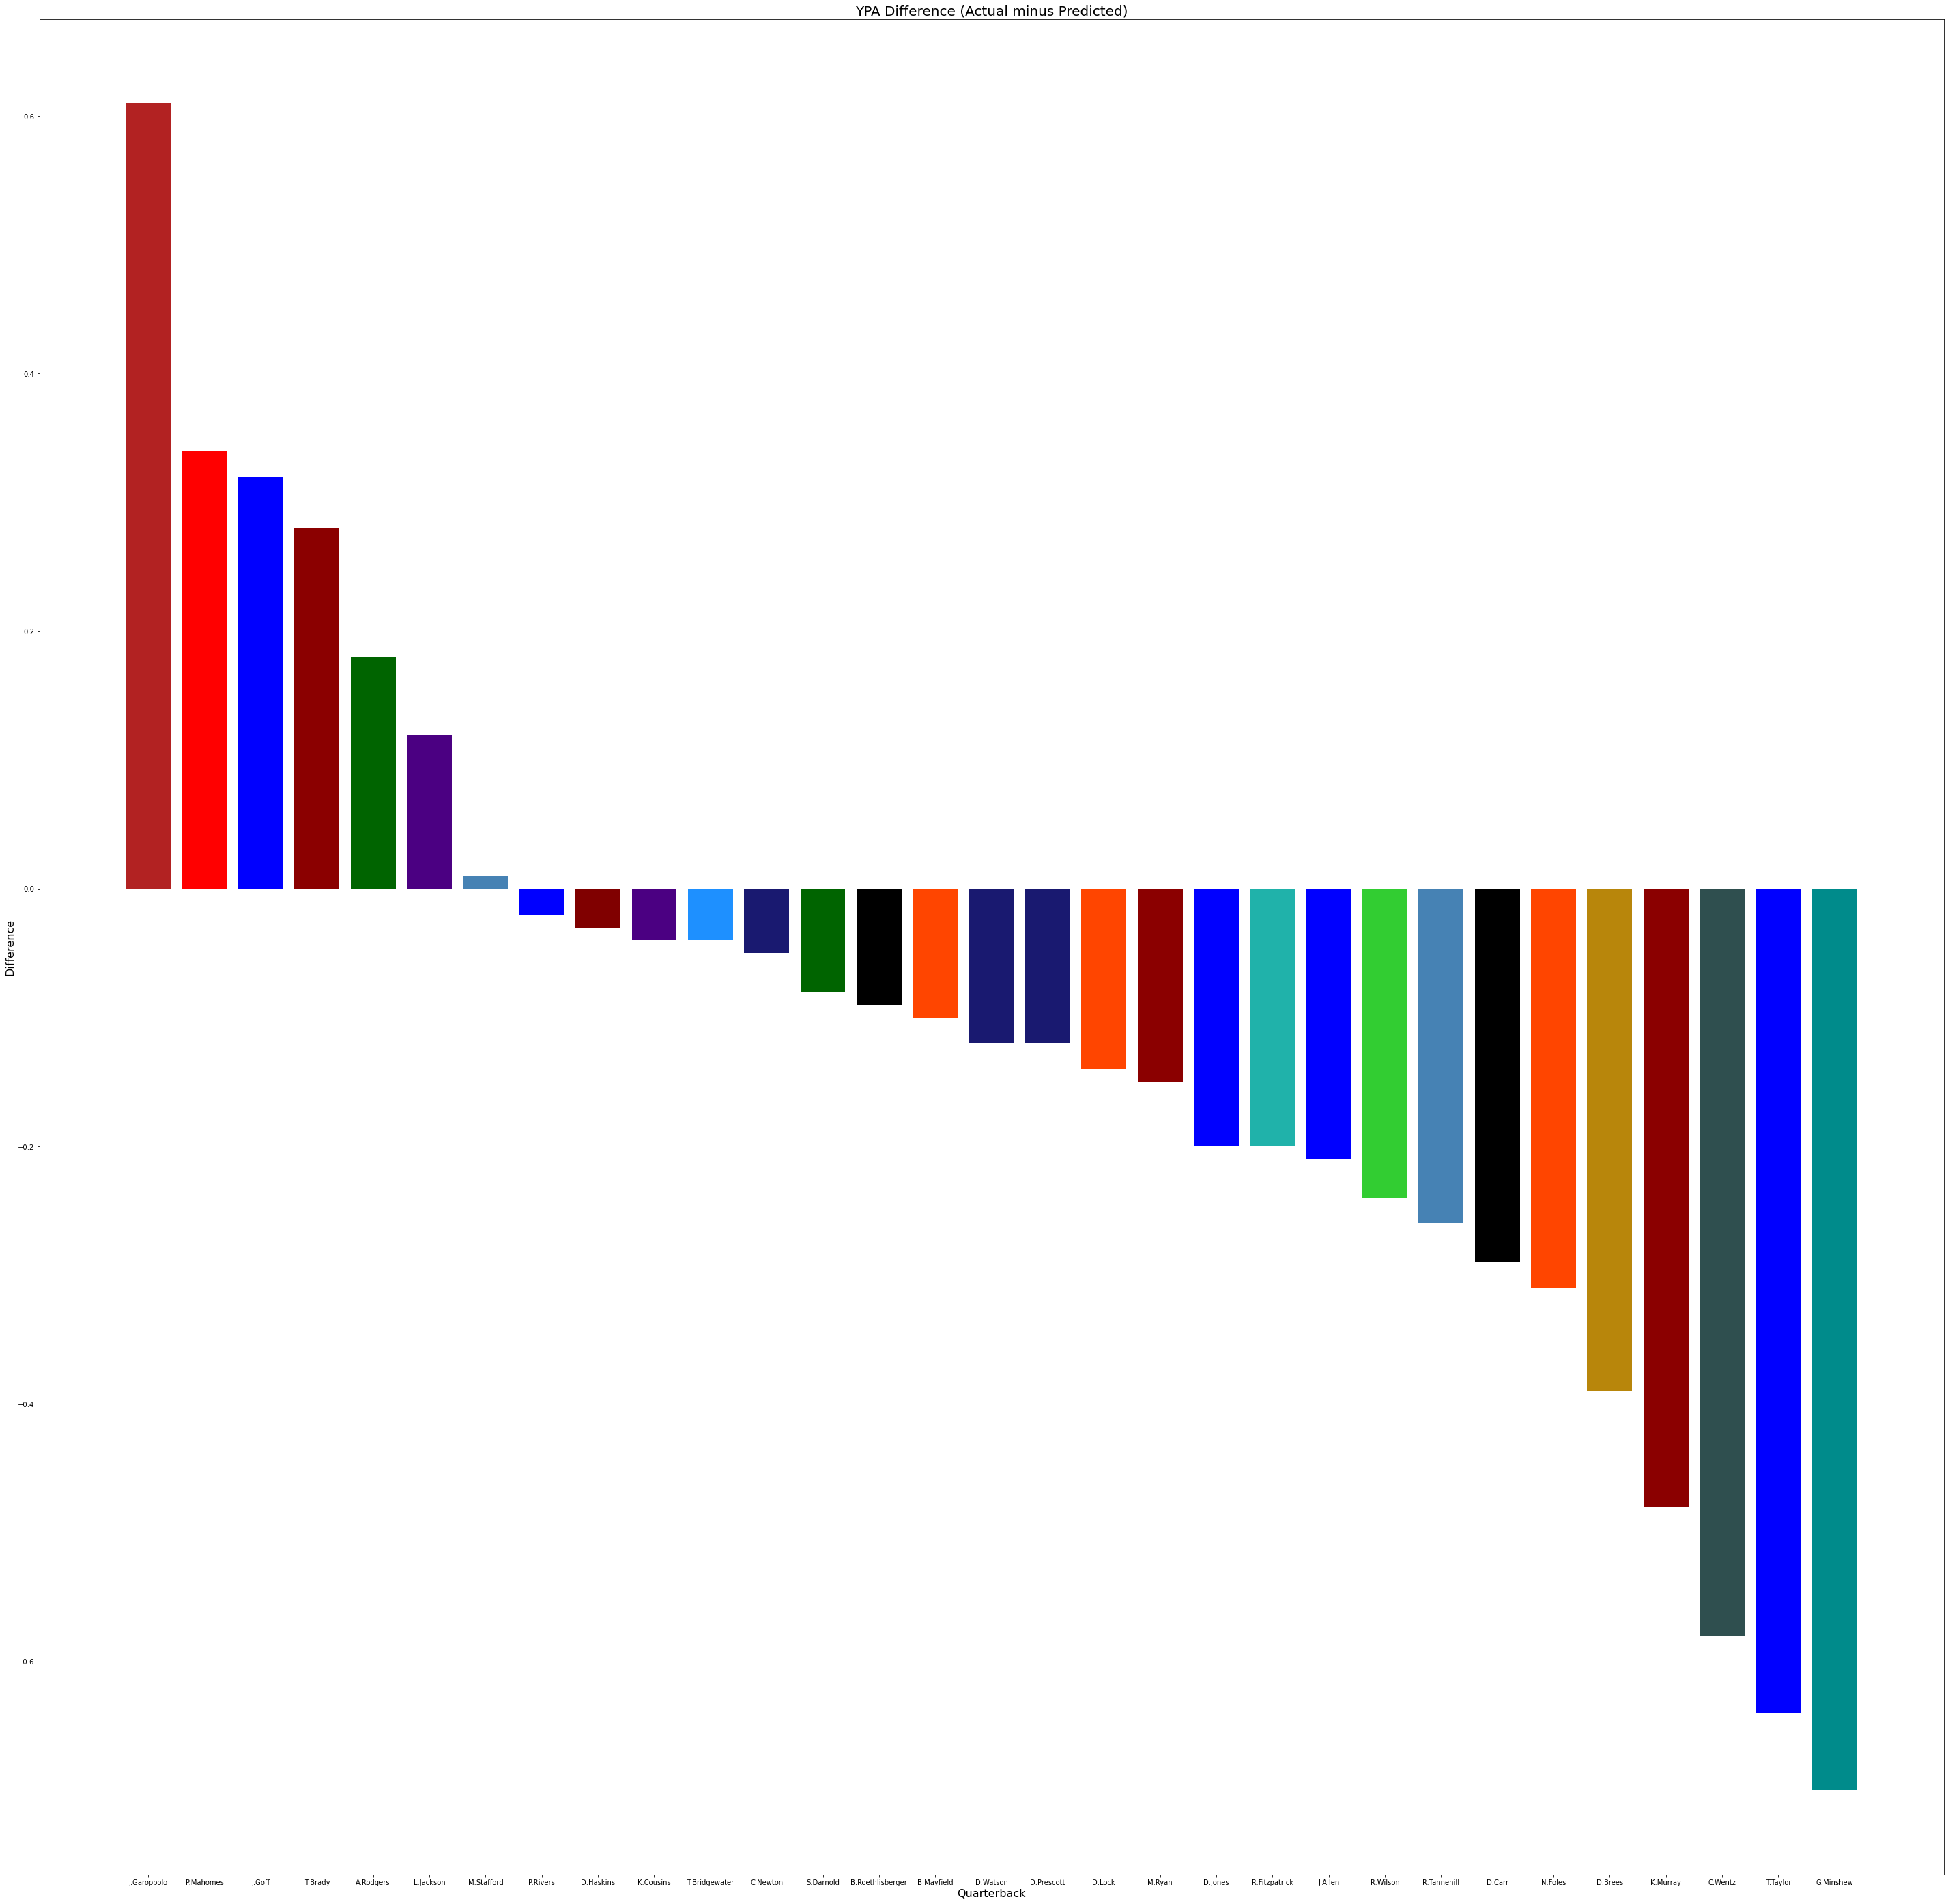

In [41]:
fig_ypa_dif, ax_ypa_dif = plt.subplots(figsize=(50, 50))
ax_ypa_dif.bar(df2_ypa.index, df2_ypa['difference'], color=[color_dict[qb] for qb in df2_ypa.index])
ax_ypa_dif.set_xlabel('Quarterback', fontsize=16)
ax_ypa_dif.set_ylabel('Difference', fontsize=16)
ax_ypa_dif.set_title('YPA Difference (Actual minus Predicted)', fontsize=20)
plt.show()